In [3]:
#Manage
import os
import random
import time

#Utils
import numpy as np
import pandas as pd

##plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

##ai_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [4]:
EPOCHS = 30
BATCH_SIZE = 128
LR = 0.001
WEIGHT_DECAY = 0.0001
SEED = 42

CLASSES = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

DATA_DIR = '/content/drive/MyDrive/AI_LAB/project/data'
RESULTS_DIR = '/content/drive/MyDrive/AI_LAB/project/result'

os.makedirs(RESULTS_DIR, exist_ok=True)

In [5]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
print(f'PyTorch version : {torch.__version__}')
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    DEVICE = torch.device('cpu')
    print('Using CPU')

print(f'Device: {DEVICE}')
print('Cores:', os.cpu_count())

PyTorch version : 2.10.0+cu128
Using GPU: Tesla T4
Device: cuda
Cores: 2


## Calculation
Computing the mean and standard deviations for faster processing by normalizing data.

In [7]:
raw_dataset = datasets.CIFAR10( root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(raw_dataset, batch_size=1000, shuffle=False, num_workers=2)

channel_sum    = torch.zeros(3)
channel_sum_sq = torch.zeros(3)
total_pixels   = 0

for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, 3, -1)

    channel_sum    += images.sum(dim=[0, 2])
    channel_sum_sq += (images ** 2).sum(dim=[0, 2])
    total_pixels   += batch_size * 32 * 32

mean = channel_sum / total_pixels
std  = torch.sqrt(channel_sum_sq / total_pixels - mean ** 2)

print(f"Mean: {mean}")
print(f"Std:  {std}")

100%|██████████| 170M/170M [03:36<00:00, 787kB/s]


Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


# Reducing Overfitting (Data Augmentatin)

We are basically adding artifical variance in the dataset

Quoting form the provided paper :

"The easiest and most common method to reduce overfitting on image data is to artificially enlarge
the dataset using label-preserving transformation"

Here ve have used in order:
- Random Clip
- Random Horizontal Flip
- Color jitter

In [8]:
# CONSTS
MEAN = mean
STD = std


# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Using provided test train set
train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

# Appying the Augmentation
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train: {len(train_dataset):,} samples | Test: {len(test_dataset):,} samples')
print(f'Train batches: {len(train_loader)} | Test batches: {len(test_loader)}')

Train: 50,000 samples | Test: 10,000 samples
Train batches: 391 | Test batches: 79


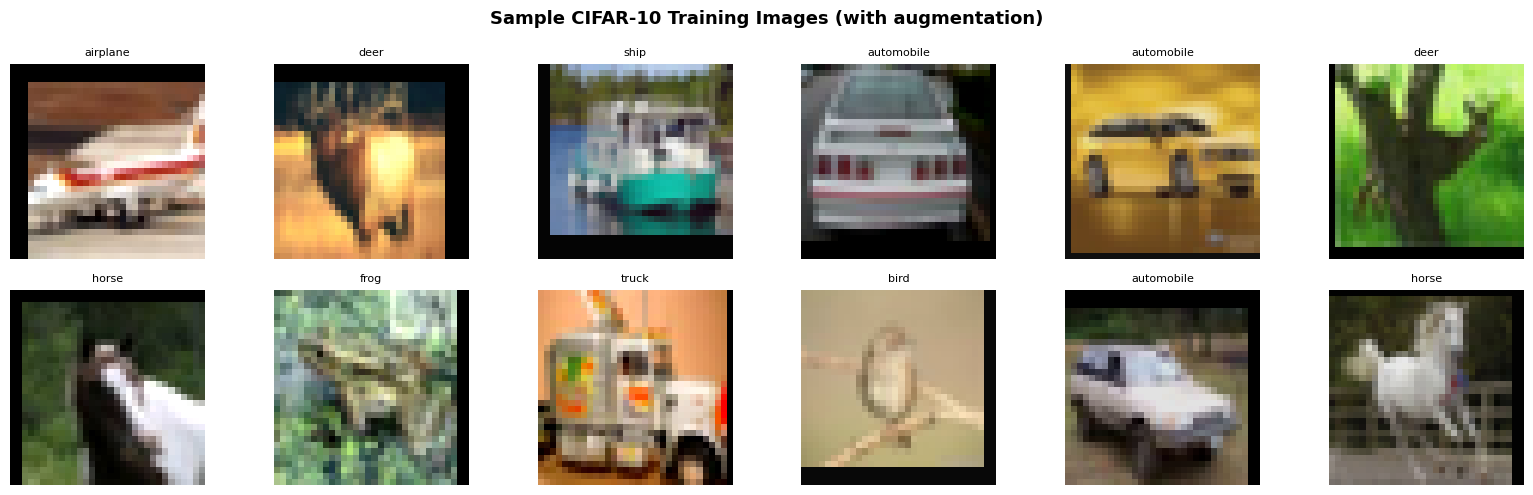

In [9]:
def imshow(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1, 2, 0)) # changing into poytorh format
    img = np.clip(img * np.array(STD) + np.array(MEAN), 0, 1)
    plt.imshow(img)
    if title: plt.title(title, fontsize=8)
    plt.axis('off')

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 6, figsize=(16, 5))
for i, ax in enumerate(axes.flat):
    plt.sca(ax)
    imshow(images[i], CLASSES[labels[i]])
plt.suptitle('Sample CIFAR-10 Training Images (with augmentation)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/sample_images.png', dpi=120, bbox_inches='tight')
plt.show()

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        """
        We are using 3*32*32 = 3072 features as input
        The output is 10 classes

        In simple NN we loose the spatial information since we flatten the image
        The BatchNormal is used to reduce computation time using the current batch
         - std dev - mean
        Droupout is used to prevent overfitting by cutting off impact of some neurons
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # Flattening of spatial data occours here

            nn.Linear(3*32*32, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super().__init__()
        """
        Here We implement the AlexNet architecture for CIFAR-10 dataset
        We are using 3*32*32 2d images as input

        There are 8 layers in total
        There are 5 layers of convolution and 3 layers of fully connected
        2 max pool layer within the 5 Convolutional layers to reduce the size of the data
        This architecture is a copy of the AlexNet architecture as provided in the resource


        The output is 10 classes
        """

        # Convolutional Layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully Connected Layer
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)

In [12]:
class ConvBlock(nn.Module):
    """
    Basic Block for CNN
    Helper class for TinyVGG
    used instead of repeating the same code multiple times
    """
    def __init__(self, in_ch, out_ch, kernel=3, pad=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel, padding=pad),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)


class TinyVGG(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super().__init__()
        """
        Tiny VGG implementation
        """

        self.block1 = nn.Sequential(
            ConvBlock(3, 32), ConvBlock(32, 32),
            nn.MaxPool2d(2, 2),#32 to 16
            nn.Dropout2d(dropout_rate),
        )
        self.block2 = nn.Sequential(
            ConvBlock(32, 64), ConvBlock(64, 64),
            nn.MaxPool2d(2, 2),# 16 to 8
            nn.Dropout2d(dropout_rate),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),# hence here 64x8x8
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )
        self._init_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    'SimpleNN': SimpleNN(dropout_rate=0.4),
    'AlexNet':  AlexNetCIFAR(num_classes=10, dropout_rate=0.5),
    'TinyVGG':  TinyVGG(num_classes=10, dropout_rate=0.3),
}

print('Model Parameter Counts:')
print('-' * 40)
for name, model in models.items():
    params = count_parameters(model)
    print(f'  {name:10s}: {params:>10,} parameters')

Model Parameter Counts:
----------------------------------------
  SimpleNN  :  3,809,034 parameters
  AlexNet   :  7,175,754 parameters
  TinyVGG   :  1,117,354 parameters


In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                out  = model(images)
                loss = criterion(out, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            out  = model(images)
            loss = criterion(out, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct    += out.argmax(1).eq(labels).sum().item()
        total      += images.size(0)

    return total_loss/total, 100.0*correct/total


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            out  = model(images)
            loss = criterion(out, labels)
            total_loss += loss.item() * images.size(0)
            correct    += out.argmax(1).eq(labels).sum().item()
            total      += images.size(0)

    return total_loss/total, 100.0*correct/total


def train_model(model, name, train_loader, test_loader,
                device, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    scaler    = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    best_acc = 0.0

    print(f'\n{"="*55}')
    ##print(f'  Training: {name}  ({count_parameters(model):,} params)')
    print(f'{"="*55}')

    start = time.time()
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        te_loss, te_acc = eval_epoch(model, test_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['test_loss'].append(te_loss)
        history['test_acc'].append(te_acc)

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), f'{name.lower()}_best.pth')

        if epoch % 5 == 0 or epoch == 1:
            print(f'  Epoch [{epoch:3d}/{epochs}] '
                  f'Train Loss: {tr_loss:.4f} Acc: {tr_acc:.2f}% | '
                  f'Test Loss: {te_loss:.4f} Acc: {te_acc:.2f}%')

    elapsed = time.time() - start
    history['total_time'] = elapsed
    history['best_acc']   = best_acc
    print(f'\n  ✓ Best Test Acc: {best_acc:.2f}%  |  Time: {elapsed:.1f}s ({elapsed/60:.1f} min)')
    return history

In [15]:
histories = {}
for name, model in models.items():
    histories[name] = train_model(
        model, name, train_loader, test_loader, DEVICE
    )

/tmp/ipython-input-3860108515.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipython-input-3860108515.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch [  1/30] Train Loss: 1.9948 Acc: 30.25% | Test Loss: 1.8093 Acc: 39.27%
  Epoch [  5/30] Train Loss: 1.7952 Acc: 40.39% | Test Loss: 1.6636 Acc: 46.16%
  Epoch [ 10/30] Train Loss: 1.7409 Acc: 43.04% | Test Loss: 1.6139 Acc: 48.46%
  Epoch [ 15/30] Train Loss: 1.6962 Acc: 44.99% | Test Loss: 1.5590 Acc: 51.71%
  Epoch [ 20/30] Train Loss: 1.6544 Acc: 47.03% | Test Loss: 1.5100 Acc: 53.84%
  Epoch [ 25/30] Train Loss: 1.6096 Acc: 49.09% | Test Loss: 1.4796 Acc: 55.35%
  Epoch [ 30/30] Train Loss: 1.5949 Acc: 49.71% | Test Loss: 1.4665 Acc: 56.04%

  ✓ Best Test Acc: 56.04%  |  Time: 1031.8s (17.2 min)

  Epoch [  1/30] Train Loss: 1.7486 Acc: 40.94% | Test Loss: 1.5588 Acc: 52.70%
  Epoch [  5/30] Train Loss: 1.1672 Acc: 71.00% | Test Loss: 1.1992 Acc: 69.56%
  Epoch [ 10/30] Train Loss: 0.9498 Acc: 81.20% | Test Loss: 1.1318 Acc: 73.68%
  Epoch [ 15/30] Train Loss: 0.8235 Acc: 86.78% | Test Loss: 0.8453 Acc: 84.92%
  Epoch [ 20/30] Train Loss: 0.7193 Acc: 91.25% | Test Loss: 0.

In [16]:

def compute_all_metrics(model, loader, device, class_names=CLASSES):
    model.eval()
    all_preds, all_targets, all_outputs = [], [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out  = model(imgs)
            all_outputs.append(out.cpu())
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_targets.extend(lbls.cpu().numpy())

    outputs_tensor = torch.cat(all_outputs)
    preds   = np.array(all_preds)
    targets = np.array(all_targets)

    return {
        'accuracy':  accuracy_score(targets, preds) * 100,
        'precision': precision_score(targets, preds, average='macro', zero_division=0) * 100,
        'recall':    recall_score(targets, preds, average='macro', zero_division=0) * 100,
        'f1':        f1_score(targets, preds, average='macro', zero_division=0) * 100,
        'cm':        confusion_matrix(targets, preds),
        'report':    classification_report(targets, preds, target_names=class_names, zero_division=0),
        'preds':     preds,
        'targets':   targets,
    }

all_metrics = {}
print('Computing test set metrics...')
for name, model in models.items():
    all_metrics[name] = compute_all_metrics(model, test_loader, DEVICE)
    m = all_metrics[name]
    print(f'\n  {name}: Acc={m["accuracy"]:.2f}%  P={m["precision"]:.2f}%  '
          f'R={m["recall"]:.2f}%  F1={m["f1"]:.2f}% ')

Computing test set metrics...

  SimpleNN: Acc=56.04%  P=55.56%  R=56.04%  F1=55.46% 

  AlexNet: Acc=91.06%  P=91.06%  R=91.06%  F1=91.05% 

  TinyVGG: Acc=77.30%  P=77.11%  R=77.30%  F1=76.98% 


In [17]:
for name, m in all_metrics.items():
    print(f'\n{"-"*55}')
    print(f'  Classification Report — {name}')
    print(f'{"-"*55}')
    print(m['report'])


-------------------------------------------------------
  Classification Report — SimpleNN
-------------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.62      0.61      0.62      1000
  automobile       0.65      0.69      0.67      1000
        bird       0.49      0.38      0.43      1000
         cat       0.40      0.38      0.39      1000
        deer       0.54      0.38      0.44      1000
         dog       0.44      0.44      0.44      1000
        frog       0.61      0.67      0.64      1000
       horse       0.58      0.69      0.63      1000
        ship       0.66      0.69      0.68      1000
       truck       0.56      0.68      0.61      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000


-------------------------------------------------------
  Classification Report — AlexNet
--

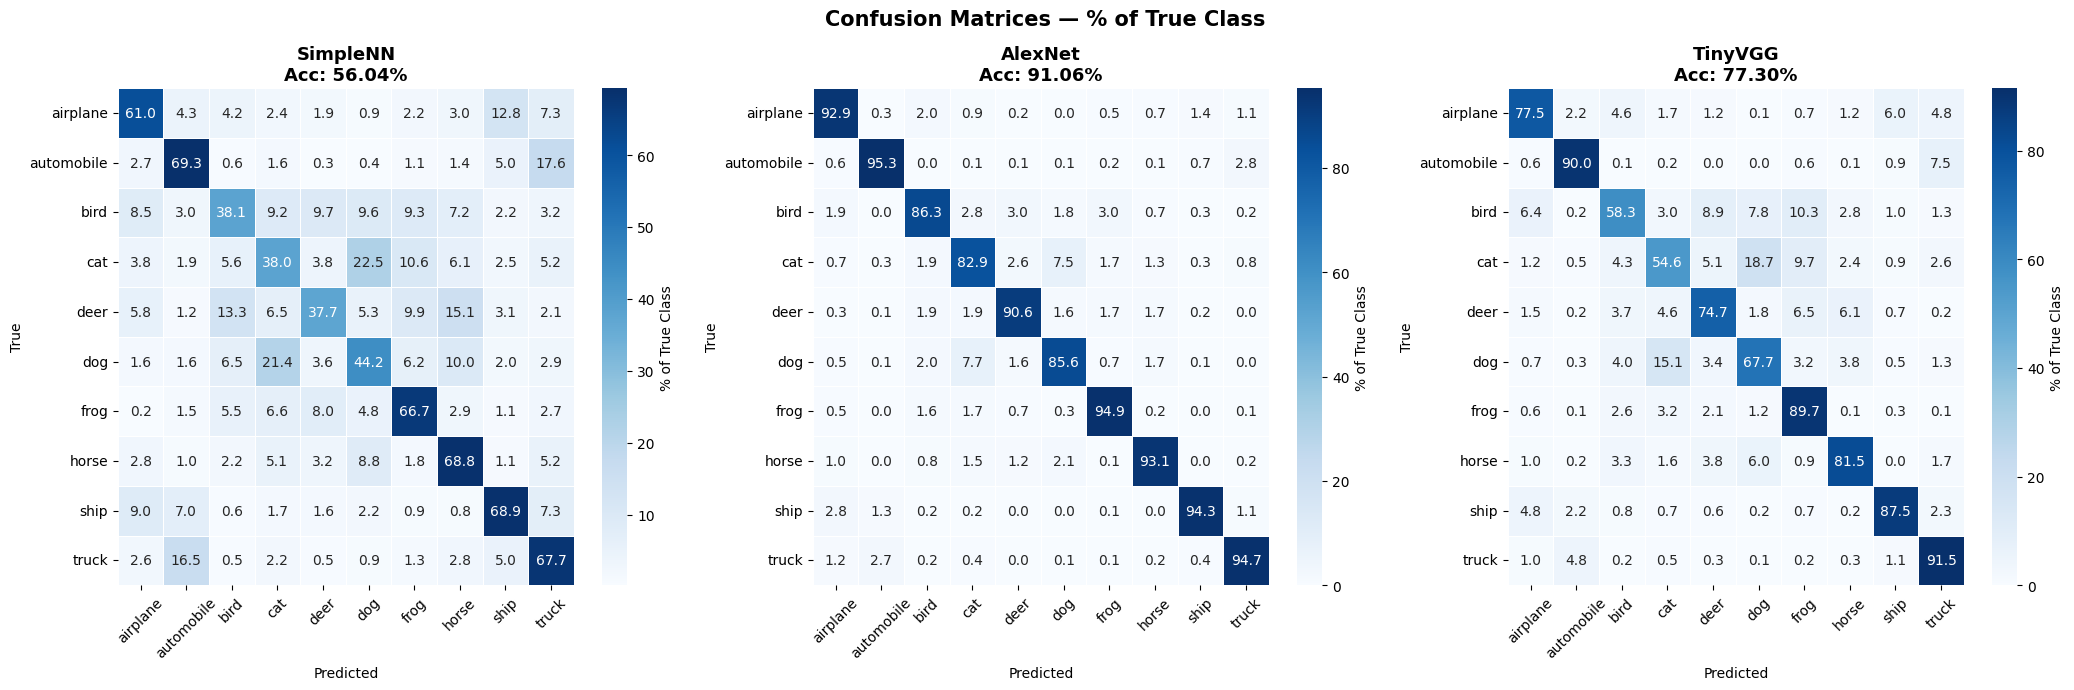

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for ax, (name, m) in zip(axes, all_metrics.items()):
    cm_pct = m['cm'].astype(float) / m['cm'].sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_pct, ax=ax, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES,
                cbar_kws={'label': '% of True Class'}, linewidths=0.4)
    ax.set_title(f'{name}\nAcc: {m["accuracy"]:.2f}%', fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Confusion Matrices — % of True Class', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
rows = []
for name in all_metrics:
    m = all_metrics[name]
    h = histories[name]
    rows.append({
        'Model':          name,
        'Accuracy (%)':   round(m['accuracy'],  2),
        'Precision (%)':  round(m['precision'], 2),
        'Recall (%)':     round(m['recall'],    2),
        'F1 (%)':         round(m['f1'],        2),
        'Params (K)':     round(count_parameters(models[name]) / 1000, 1),
        'Train Time (s)': round(h['total_time'], 1),
    })

df = pd.DataFrame(rows).set_index('Model')
print('\n' + '='*75)
print('  FINAL COMPARISON TABLE')
print('='*75)
print(df.to_string())
print('='*75)
df


  FINAL COMPARISON TABLE
          Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  Params (K)  Train Time (s)
Model                                                                                
SimpleNN         56.04          55.56       56.04   55.46      3809.0          1031.8
AlexNet          91.06          91.06       91.06   91.05      7175.8          1157.9
TinyVGG          77.30          77.11       77.30   76.98      1117.4           996.7


,Accuracy (%),Precision (%),Recall (%),F1 (%),Params (K),Train Time (s)
Model,,,,,,
SimpleNN,56.04,55.56,56.04,55.46,3809.0,1031.8
AlexNet,91.06,91.06,91.06,91.05,7175.8,1157.9
TinyVGG,77.30,77.11,77.30,76.98,1117.4,996.7


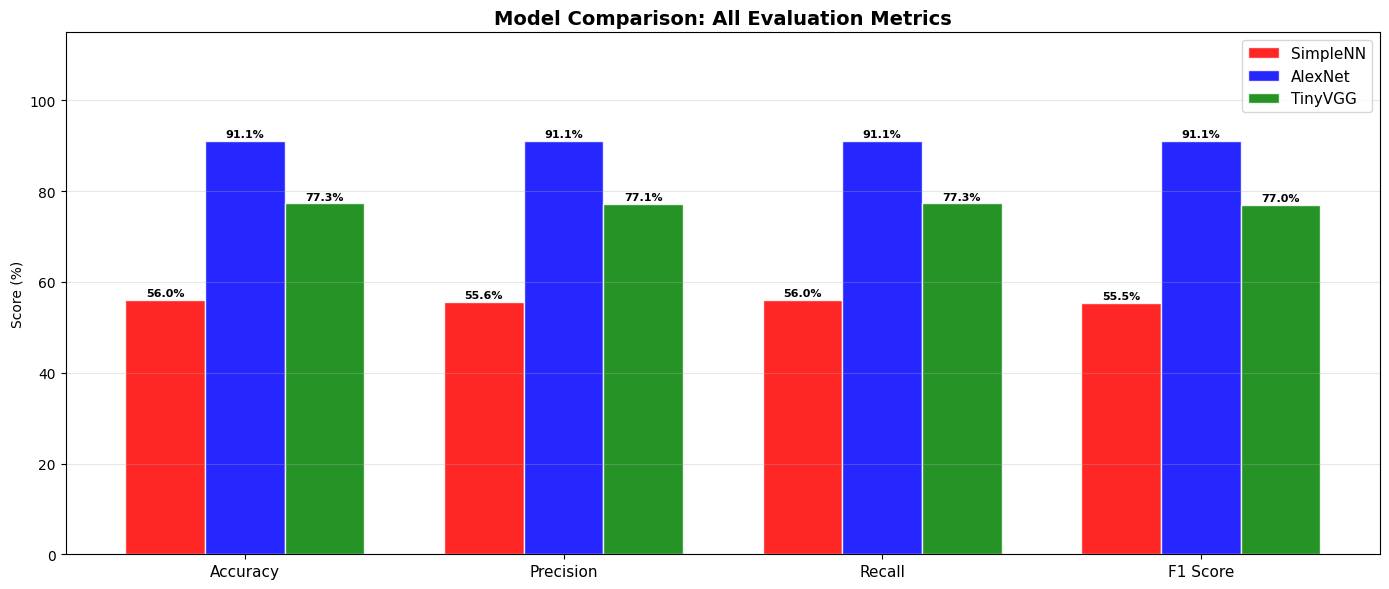

In [21]:
metric_keys   = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
names  = list(all_metrics.keys())
x      = np.arange(len(metric_keys))
width  = 0.25
colors_list = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(14, 6))
for i, (name, color) in enumerate(zip(names, colors_list)):
    vals = [all_metrics[name][k] for k in metric_keys]
    bars = ax.bar(x + i*width, vals, width, label=name, color=color, alpha=0.85, edgecolor='white')
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.4,
                f'{v:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xticks(x + width); ax.set_xticklabels(metric_labels, fontsize=11)
ax.set_ylabel('Score (%)'); ax.set_ylim(0, 115)
ax.set_title('Model Comparison: All Evaluation Metrics', fontsize=14, fontweight='bold')
ax.legend(fontsize=11); ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/metric_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Discussion and Conclusion

Dataset: CIFAR-10 dataset has 10 labels and 60K images of 3x32x32
3 channel, 32 width, 32 height. in pixel

Neural Network We are using 3x32x32 = 3072 features as input
The output is 10 classes

In simple NN we loose the spatial information since we flatten the image
The BatchNormal is used to reduce computation time using the current batch
Droupout is used to prevent overfitting by cutting off impact of some neurons

Here We implement the AlexNet architecture for CIFAR-10 dataset
We are using 3x32x32 2d images as input
There are 8 layers in total
There are 5 layers of convolution and 3 layers of fully connected
2 max pool layer within the 5 Convolutional layers to reduce the size of the data
This architecture is a copy of the AlexNet architecture as provided in the resource

Tiny VGG
There are 2 Convolution blocks with a max pooling for both with 2 Convolutional layers.
and a pooling layer then there are two fully connected layers completing the tiny VGG architecture

## Prediction
The Simple NN should do the worst since it loses dimentionality and brute forces the computation
The Tiny VGG and AlexNet should work much better.
In comparision Tiny VGG should be lightweight but AlexNet performance should be better

# The metrics

1. Accuracy
It given the fraction of correctly predicted samples out of all samples.
Overall performance of the model. High accuracy does not always mean good performance for imbalanced classes.
Formula: Num of Correct Predictions/ Total Predctions

2. Precision
It is the measures correctness of positive predictions. High precision = model rarely labels something as a class incorrectly.
Formula (per class): TP/ TP + FP

3. Recall (Sensitivity)
Out of all actual samples of a class, how many were correctly identified by the model.
Measures completeness. High recall = model detects most of the actual class instances.
Formula (per class): TP / TP + FN

4. F1-Score
Harmonic mean of precision and recall.
Balances precision and recall. Useful when you want a single metric for class performance, especially in imbalanced datasets.
Formula: 2 (Precision * Rceall)/(Precison + Recall)

5. Confusion Matrix (CM)
A table showing actual vs predicted classes.
Structure:

# Results

